# Clerical Review Prototype
### Jono - 31/07/2023


In [ ]:
# Install Packages - Note: FuzzyWuzzy is NOT currently available in NGI, but you can use the workaround below
!pip install fuzzywuzzy python-Levenshtein
import pandas as pd
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt

In [261]:
# Calculate levenshtein distance
# def levenshtein_distance(string1, string2):
#     size_x = len(string1) + 1
#     size_y = len(string2) + 1
#     matrix = [[0] * size_y for _ in range(size_x)]
#     for x in range(size_x):
#         matrix[x][0] = x
#     for y in range(size_y):
#         matrix[0][y] = y

#     for x in range(1, size_x):
#         for y in range(1, size_y):
#             if string1[x-1] == string2[y-1]:
#                 matrix[x][y] = min(
#                     matrix[x-1][y] + 1,
#                     matrix[x-1][y-1],
#                     matrix[x][y-1] + 1
#                 )
#             else:
#                 matrix[x][y] = min(
#                     matrix[x-1][y] + 1,
#                     matrix[x-1][y-1] + 1,
#                     matrix[x][y-1] + 1
#                 )
#     return matrix[size_x - 1][size_y - 1]

# def fuzzy_score(string1, string2):
#     levenshtein = levenshtein_distance(string1, string2)
#     longest_length = max(len(string1), len(string2))
#     return (1 - levenshtein / longest_length) * 100

In [262]:
# Load the dummy data
spine = pd.read_csv('spine.csv')
dataset = pd.read_csv('dataset.csv')
matches = pd.read_csv('matches.csv')

print('Dummy Spine')
print(spine)
print('\nDummy Dataset')
print(dataset)
print('\nLinkage Concordance')
print(matches)

Dummy Spine
   id first_name surname  sex         dob
0   1       John    Smit    1  02/01/2011
1   2  Christine    Jobs    2  12/12/1986
2   3      Chris   Cross    1  11/11/1976
3   4        Ron      Da    1  01/05/2011
4   5        Ben   Dover    1  12/02/1996
5   6       Eddy   Jones    1  10/08/1950
6   7     Ashley   Smith    2  01/02/1933
7   8       Bill   Sykes    1  02/03/1944
8   9     Oliver   Twist    1  04/05/1945
9  10       Rose  Wilkes    2  12/11/2021

Dummy Dataset
   id first_name surname  sex         dob
0   1       John   Smith    1  01/01/2011
1   2  Christine   Jones    2  10/09/1964
2   3      Chris   Cross    1  11/11/1976
3   4        Ron      Da    1  01/05/2011
4   5        Ben   Dover    1  12/02/1986
5   6      Eddie   Jones    1  10/08/1950
6   7     Ashley   Smith    2  01/02/1933
7   8       Bill   Sykes    1  02/03/1944
8   9     Oliver   Twist    1  04/05/1945
9  10      Rosie  Wilkes    2  12/11/2021

Linkage Concordance
   id1  id2  pass
0    1    

In [263]:
# Passes List
print('Pass 1: FN, SN, SEX, DOB')
print('Pass 2: SN, SEX, DOB')
print('Pass 3: FN, SN, SEX')
print('Pass 4: FN, SEX')

Pass 1: FN, SN, SEX, DOB
Pass 2: SN, SEX, DOB
Pass 3: FN, SN, SEX
Pass 4: FN, SEX


In [264]:
# Define your weights here. The lower the weight, the smaller the impact on the combined score
weights = {
    'first_name': 0.5,
    'surname': 0.7,
    'sex': 0.8,
    'dob': 1.0,
}

# Calculating the minimum and maximum possible scores (used later to normalise weights)
min_score = 0
max_score = sum(weights.values()) * 100

In [265]:
# Join the dataframes on the relevant ID columns
df = pd.merge(matches, spine, left_on='id1', right_on='id')
df = pd.merge(df, dataset, left_on='id2', right_on='id', suffixes=('_spine', '_dataset'))

In [266]:
 # Calculate the fuzzy scores for each feature
for feature in weights.keys():
    df[f'{feature}_score'] = df.apply(lambda row: fuzz.ratio(str(row[f'{feature}_spine']), str(row[f'{feature}_dataset'])), axis=1)
    # This second option will take longer but will work in NGI without FuzzyWuzzy
    # df[f'{feature}_score'] = df.apply(lambda row: fuzzy_score(str(row[f'{feature}_spine']), str(row[f'{feature}_dataset'])), axis=1)

# Calculate combined score (average of fuzzy scores)
df['average_score'] = df[[f'{feature}_score' for feature in weights.keys()]].mean(axis=1)

# Calculate weighted score (sum of weighted scores)
df['weighted_score'] = sum(df[f'{feature}_score'] * weight for feature, weight in weights.items())

# Normalize the weighted score
df['weighted_score'] = round(((df['weighted_score'] - min_score) / (max_score - min_score)) * 100,2)

In [267]:
# Create linkage_scores df and print
linkage_scores = df[['id1', 'id2', 'pass'] + [f'{feature}_score' for feature in weights.keys()] + ['average_score', 'weighted_score']].sort_values('weighted_score', ascending=False)
print('Print all linkage scores')
linkage_scores.head(10)

Print all linkage scores


,id1,id2,pass,first_name_score,surname_score,sex_score,dob_score,average_score,weighted_score
2,3,3,1,100,100,100,100,100.00,100.00
3,4,4,1,100,100,100,100,100.00,100.00
6,7,7,1,100,100,100,100,100.00,100.00
7,8,8,1,100,100,100,100,100.00,100.00
8,9,9,1,100,100,100,100,100.00,100.00
9,10,10,2,89,100,100,100,97.25,98.17
4,5,5,3,100,100,100,90,97.50,96.67
5,6,6,2,67,100,100,100,91.75,94.50
0,1,1,4,100,89,100,90,94.75,94.10
1,2,2,4,100,67,100,60,81.75,78.97


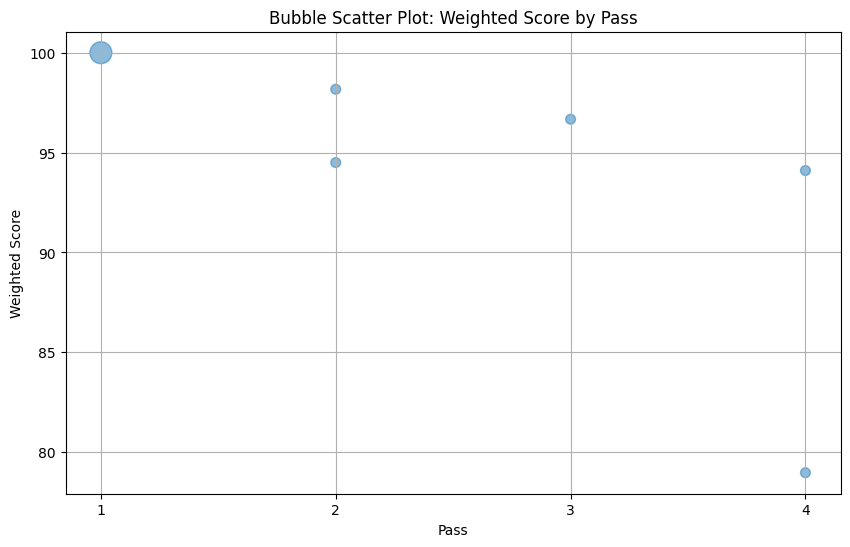

In [279]:
# Group by 'pass' and 'weighted_score', calculate the size for each group
grouped = df.groupby(['pass', 'weighted_score']).size().reset_index(name='counts')

plt.figure(figsize=(10, 6))

# Visualise results and print chart with weighted score by pass
plt.scatter(grouped['pass'], grouped['weighted_score'], s=grouped['counts']*50, alpha=0.5)

plt.xlabel('Pass')
plt.ylabel('Weighted Score')
plt.title('Bubble Scatter Plot: Weighted Score by Pass')
plt.xticks([1, 2, 3, 4])
plt.grid(True)
plt.show()

In [271]:
# Set weighted score threshold to filter records
threshold = 95
linkage_scores_filtered = linkage_scores[linkage_scores.weighted_score < threshold]
linkage_scores_filtered

,id1,id2,pass,first_name_score,surname_score,sex_score,dob_score,average_score,weighted_score
5,6,6,2,67,100,100,100,91.75,94.50
0,1,1,4,100,89,100,90,94.75,94.10
1,2,2,4,100,67,100,60,81.75,78.97


In [272]:
# Filter the original dataframe for rows where 'weighted_score' is less than the threshold
original_values = df[(df['weighted_score'] < threshold)][['id1', 'id2', 'pass','first_name_spine', 'first_name_dataset',
                                                    'surname_spine', 'surname_dataset', 'sex_spine', 'sex_dataset',
                                                    'dob_spine', 'dob_dataset']]

original_values.columns = ['id1', 'id2', 'pass', 'first_name_1', 'first_name_2', 'surname_1', 'surname_2', 'sex_1', 'sex_2', 'dob_1', 'dob_2']
original_values

,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2
0,1,1,4,John,John,Smit,Smith,1,1,02/01/2011,01/01/2011
1,2,2,4,Christine,Christine,Jobs,Jones,2,2,12/12/1986,10/09/1964
5,6,6,2,Eddy,Eddie,Jones,Jones,1,1,10/08/1950,10/08/1950


In [273]:
# We can drill down to particular passes too
pass_filter = 4
print(f'View records from pass {pass_filter}')
original_values[original_values['pass'] == pass_filter]

View records from pass 4


,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2
0,1,1,4,John,John,Smit,Smith,1,1,02/01/2011,01/01/2011
1,2,2,4,Christine,Christine,Jobs,Jones,2,2,12/12/1986,10/09/1964


In [274]:
def accept_or_reject_matches(df):
    # Create a new column for the user's decision
    df['user_decision'] = ''

    for index, row in df.iterrows():
        print(f"\nRow {index}:")
        print(row)

        decision = input("\nEnter '1' to accept the match, or '2' to reject it: ")
        while decision not in ['1', '2']:
            print("\nInvalid input. Please enter '1' to accept the match, or '2' to reject it.")
            decision = input("\nEnter '1' to accept the match, or '2' to reject it: ")

        df.at[index, 'user_decision'] = decision

    return df

clerical_review = accept_or_reject_matches(original_values)


Row 0:
id1                       1
id2                       1
pass                      4
first_name_1           John
first_name_2           John
surname_1              Smit
surname_2             Smith
sex_1                     1
sex_2                     1
dob_1            02/01/2011
dob_2            01/01/2011
user_decision              
Name: 0, dtype: object

Enter '1' to accept the match, or '2' to reject it: 1

Row 1:
id1                       2
id2                       2
pass                      4
first_name_1      Christine
first_name_2      Christine
surname_1              Jobs
surname_2             Jones
sex_1                     2
sex_2                     2
dob_1            12/12/1986
dob_2            10/09/1964
user_decision              
Name: 1, dtype: object

Enter '1' to accept the match, or '2' to reject it: 2

Row 5:
id1                       6
id2                       6
pass                      2
first_name_1           Eddy
first_name_2          Eddie
surname_

In [275]:
accepted_matches = (clerical_review['user_decision'] == '1').sum()
rejected_matches = (clerical_review['user_decision'] == '2').sum()

print(f"Number of accepted matches: {accepted_matches}")
print(f"Number of rejected matches: {rejected_matches}\n")
print('Clerical Review Table')

clerical_review

Number of accepted matches: 2
Number of rejected matches: 1

Clerical Review Table


,id1,id2,pass,first_name_1,first_name_2,surname_1,surname_2,sex_1,sex_2,dob_1,dob_2,user_decision
0,1,1,4,John,John,Smit,Smith,1,1,02/01/2011,01/01/2011,1
1,2,2,4,Christine,Christine,Jobs,Jones,2,2,12/12/1986,10/09/1964,2
5,6,6,2,Eddy,Eddie,Jones,Jones,1,1,10/08/1950,10/08/1950,1
